### plot_time_course

In [91]:
#!/usr/bin/env python3
# coding: utf-8

import os, re, sys
import glob, json
import argparse

import numpy as np
import pandas as pd
from scipy.io import loadmat

import matplotlib.pyplot as plt
import seaborn as sns

from pctk import multicellds 

# modules_path = "../"
# modules_path = os.path.dirname(os.path.realpath(__file__))
# modules_path= os.path.join(modules_path, 'scripts/')
# modules_path= os.path.join(modules_path, 'modules')
# sys.path.append(modules_path)

sns.set(style="ticks", palette="Paired")
sns.set_context('paper')

def create_parser():
    parser = argparse.ArgumentParser(description="Plot total cell grouped as Alive/Necrotic/Apoptotic vs Time")
    
    parser.add_argument("data_folder", action="store", help="folder were the data is stored")
    
    parser.add_argument("--format", action="store", dest="format", choices=("physicell", "physiboss"),
                        help="Format of the input data", default="physicell")

    parser.add_argument("--figout", action="store", dest="fig_fname", default="./cell_vs_time.png",
                        help="File name to save the plot")
                        
    parser.add_argument("--csvout", action="store", dest="csv_fname", default=None,
                        help="File name to store the summary table used for the plot")

    return parser
    
def pb_output_iterator(data_folder, sep=";"):
    globing = os.path.join(data_folder, "cells_[0-9]*.txt")
    for fname in sorted(glob.glob(globing)):
        df = pd.read_csv(fname, sep=sep)
        t = df.Time[0]
        yield (t, df)

def count_pb_files(data_folder):
    globing = os.path.join(data_folder, "cells_[0-9]*.txt")
    return len(glob.glob(globing))

In [92]:
# parser = create_parser()
# args = parser.parse_args()
name = "output"
data_folder = f"../../../../{name}"
print (data_folder)
fig_fname  = name
csv_fname = name

phases_dict = multicellds.default_phases_dict
phase_grouping = multicellds.default_phase_grouping
print(phases_dict)
print(phase_grouping)

# Globing output files according to the output format specified
# if args.format == 'physicell':
phase_col = "current_phase"
mcds = multicellds.MultiCellDS(output_folder=data_folder)
df_iterator = mcds.cells_as_frames_iterator()
num_of_files = mcds.cells_file_count()
# elif args.format == 'physiboss':
#     phase_col = "phase"
#     df_iterator = pb_output_iterator(args.data_folder)
#     num_of_files = count_pb_files(args.data_folder)

# Initializing a Pandas Databrafe to store the data
columns = ["time", "alive", "apoptotic", "necrotic"]
data = np.zeros((num_of_files, 4), dtype=int)
df_time_course = pd.DataFrame(columns=columns, data=data)

../../../../output
{0: 'Ki67_positive_premitotic', 1: 'Ki67_positive_postmitotic', 2: 'Ki67_positive', 3: 'Ki67_negative', 4: 'G0G1_phase', 5: 'G0_phase', 6: 'G1_phase', 7: 'G1a_phase', 8: 'G1b_phase', 9: 'G1c_phase', 10: 'S_phase', 11: 'G2M_phase', 12: 'G2_phase', 13: 'M_phase', 14: 'live', 100: 'apoptotic', 101: 'necrotic_swelling', 102: 'necrotic_lysed', 103: 'necrotic', 104: 'debris'}
{'Ki67_positive_premitotic': 'alive', 'Ki67_positive_postmitotic': 'alive', 'Ki67_positive': 'alive', 'Ki67_negative': 'alive', 'G0G1_phase': 'alive', 'G0_phase': 'alive', 'G1_phase': 'alive', 'G1a_phase': 'alive', 'G1b_phase': 'alive', 'G1c_phase': 'alive', 'S_phase': 'alive', 'G2M_phase': 'alive', 'G2_phase': 'alive', 'M_phase': 'alive', 'live': 'alive', 'apoptotic': 'apoptotic', 'necrotic_lysed': 'necrotic', 'necrotic_swelling': 'necrotic'}


In [93]:
print("Reading cell_output files from %i input files from %s" % (num_of_files, data_folder))
# Iterating over all cell_output files
for i, (t, df) in enumerate(df_iterator):
    print("\tProcessing time step: %.0f" % t)

    # Rename the phases integer codes using the phases_dict as the mapping
    s = df[phase_col]
    s.replace(to_replace=phases_dict, inplace=True)
    
    # Count the number of cells in each phase
    counts = s.value_counts()

    df_time_course.loc[i, 'time'] = t
    # group the previous phases count into the three general classes:
    # Alive, Apoptotic, Necrotic
    for k, v in counts.to_dict().items():
        if k not in phase_grouping:
            continue
        df_time_course.loc[i, phase_grouping[k]] += v

Reading cell_output files from 49 input files from ../../../../output
	Processing time step: 0
	Processing time step: 30
	Processing time step: 60
	Processing time step: 90
	Processing time step: 120
	Processing time step: 150
	Processing time step: 180
	Processing time step: 210
	Processing time step: 240
	Processing time step: 270
	Processing time step: 300
	Processing time step: 330
	Processing time step: 360
	Processing time step: 390
	Processing time step: 420
	Processing time step: 450
	Processing time step: 480
	Processing time step: 510
	Processing time step: 540
	Processing time step: 570
	Processing time step: 600
	Processing time step: 630
	Processing time step: 660
	Processing time step: 690
	Processing time step: 720
	Processing time step: 750
	Processing time step: 780
	Processing time step: 810
	Processing time step: 840
	Processing time step: 870
	Processing time step: 900
	Processing time step: 930
	Processing time step: 960
	Processing time step: 990
	Processing time 

Finish processing files
Creating figure
Saving fig as output


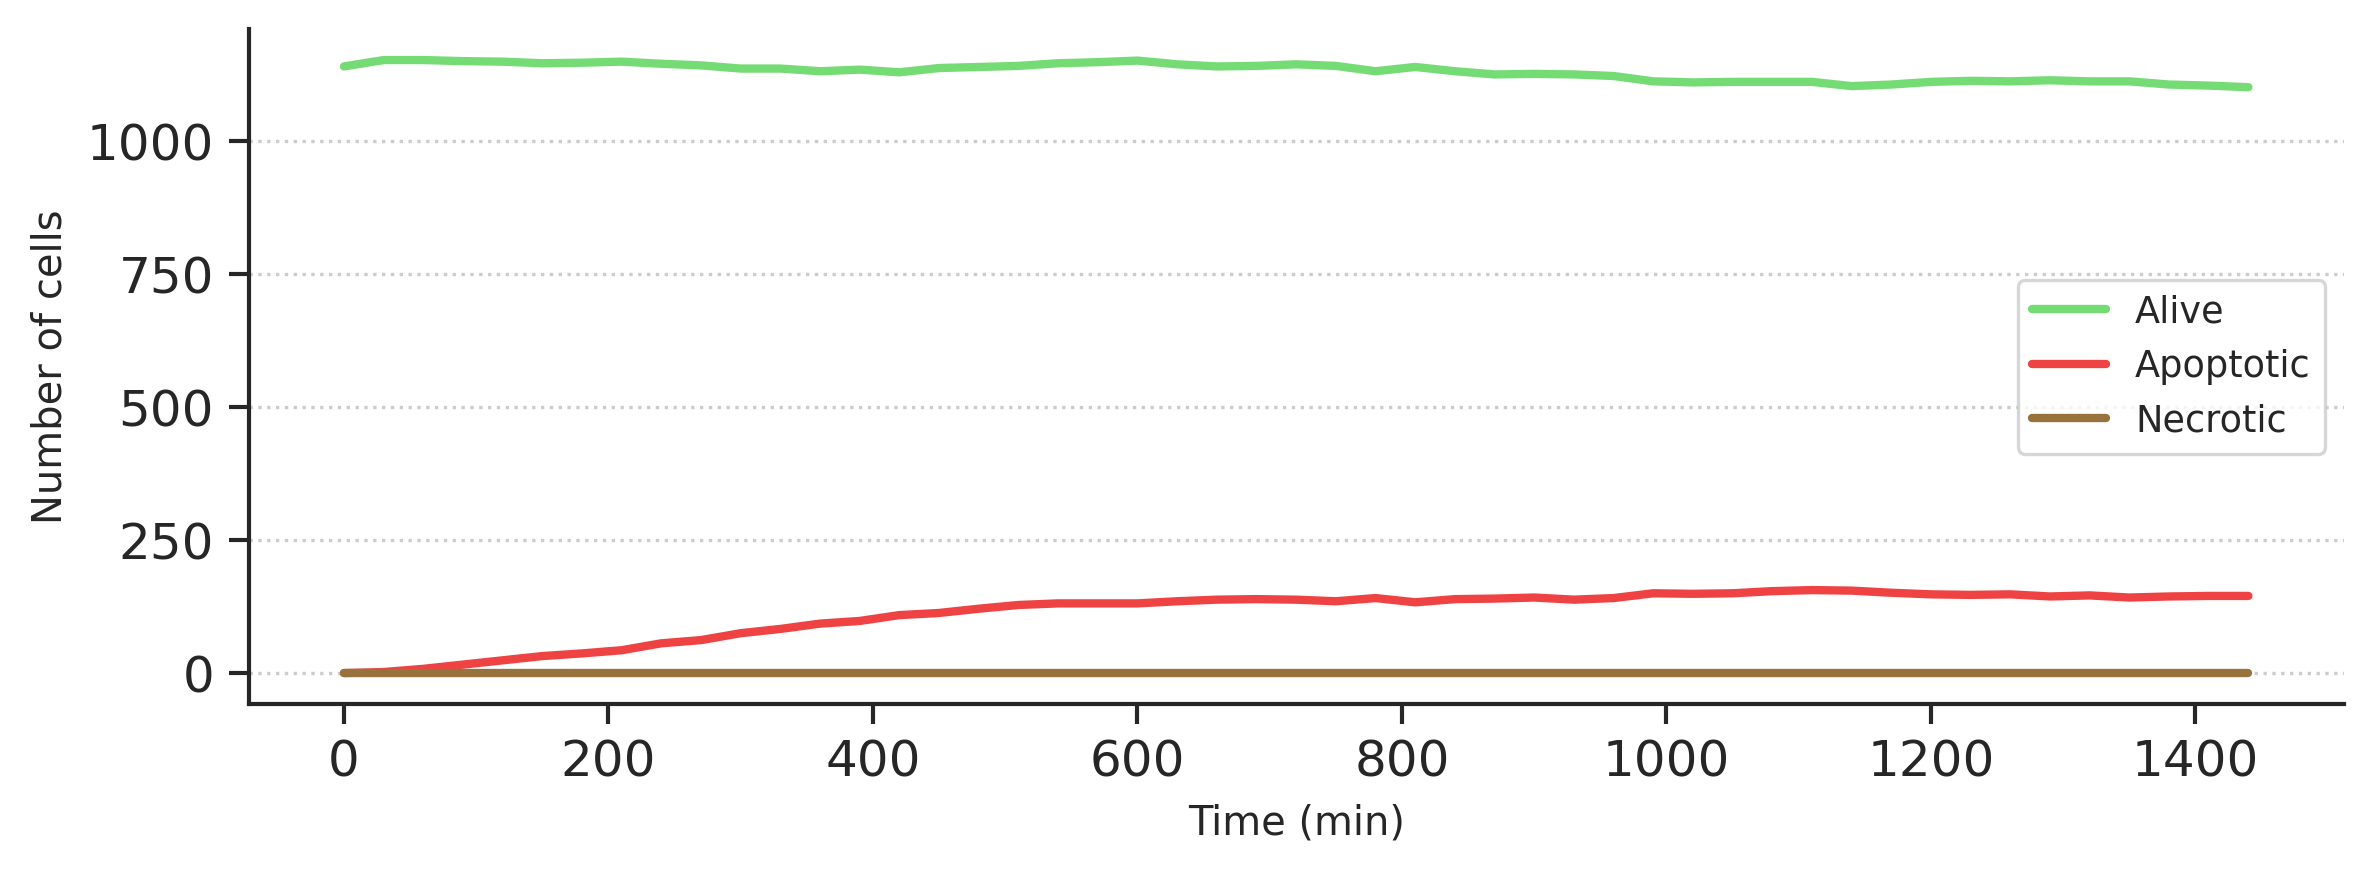

In [94]:
print("Finish processing files")    
# Set time column as the dataframe index
sns.set_context('paper')
patch_color = "lightgrey"

print("Creating figure")
# Create a figure
fig, ax = plt.subplots(1, 1, figsize=(8,3), dpi=300)

# plot Alive vs Time
curve_params = {}
curve_params['alive'] = {'color': '#75db75', 'label': 'Alive'}
curve_params['apoptotic'] = {'color': '#ef4242', 'label': 'Apoptotic'}
curve_params['necrotic'] = {'color':'#97723d', 'label': 'Necrotic'}
line_width = 2.
for k,pdict in curve_params.items():
    c = pdict['color']
    l = pdict['label']
    ax.plot(df_time_course.time, df_time_course[k], "-", c=c, label=l, linewidth=line_width)

# setting axes labels
ax.set_xlabel("Time (min)")
ax.set_ylabel("Number of cells")

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Showing legend
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(linestyle='dotted')
ax.legend()

fig.tight_layout()
fig.savefig(fig_fname)
print("Saving fig as %s" % fig_fname)

# if csv_fname:
#     df_time_course.to_csv(csv_fname+".csv", sep="\t")
#     print("Saving csv as %s" % csv_fname)